# **Utility Function**

In [ ]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import splitfolders
import random
import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
import tensorflow as tf
import itertools

import keras
import torch
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from keras import Model, layers
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

device = get_default_device()
device

device(type='cuda')

In [ ]:
def split():
    data_dir = os.path.join('/content/drive/MyDrive/data_categorised_rgb')
    print("No of images in each class of data directory")
    for dir, subdir, files in os.walk(data_dir):
        print(dir,':', str(len(files)))
        
    splitfolders.ratio("/content/drive/MyDrive/data_categorised_rgb", 
                       output = "/content/drive/MyDrive",
                       seed = 6, 
                       ratio = (0.7, 0.2, 0.1), 
                       group_prefix = None, 
                       move = False)

if os.path.exists("/content/drive/MyDrive/multiclass_data_folders/train"):
    print("Files already present in splitted format")
else:
    split()
    print("Files are splitted in the ratio 0.8, 0.2")

Files already present in splitted format


In [ ]:
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()

In [ ]:
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()

In [ ]:
def do_history_stuff(history, history_file_name, isinception=False):
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)
    plot_f1_from_history(history)

In [ ]:
def plot_f1_from_history(history):
    color = sns.color_palette()
    f1 = history.history['f1']
    val_f1 = history.history['val_f1']
    epochs = range(len(f1))
    sns.lineplot(epochs, f1, label='Training F1')
    sns.lineplot(epochs, val_f1, label='Validation F1')
    plt.title('Training and Validation Score')
    plt.legend()
    plt.figure()
    plt.show()

In [ ]:
def f1(y_true, y_pred):    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(
                               K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall    
    def precision(y_true, y_pred):
       
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +  K.epsilon())
        return precision    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
train_folders = '/content/drive/MyDrive/multiclass_data_folders/train'
val_folders = '/content/drive/MyDrive/multiclass_data_folders/val'

We are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance.
We are only normalising to make the prediction, the other parameters were used for agumentation and train weights

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1.0/255., rotation_range = 10)
train_generator = train_datagen.flow_from_directory(train_folders, batch_size=2, class_mode='categorical', target_size = (310, 310))

validation_datagen = ImageDataGenerator(rescale = 1.0/255.) 
validation_generator = validation_datagen.flow_from_directory(val_folders, batch_size=1, class_mode='categorical', target_size=(310, 310))

Found 1473 images belonging to 5 classes.
Found 371 images belonging to 5 classes.


In [ ]:
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(validation_generator.class_indices)
print(inv_map_classes)

{'CS(40-50)': 0, 'D(20-25)': 1, 'DD(30-35)': 2, 'SevereCS(55-65)': 3, 'VSCS(70-90)': 4}
{0: 'CS(40-50)', 1: 'D(20-25)', 2: 'DD(30-35)', 3: 'SevereCS(55-65)', 4: 'VSCS(70-90)'}


In [ ]:
def show_few_images(number_of_examples = 2, predict_using_model = None):
    figure1, ax1 = plt.subplots(number_of_examples,len(os.listdir(train_folders)), figsize=(20,4*number_of_examples))
    ax1 = ax1.reshape(-1)
    axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
    axoff_fun(ax1)
    axs = 0
    for i, folder in enumerate(os.listdir(train_folders)):
        image_ids = os.listdir(os.path.join(train_folders,folder))
        for j in [random.randrange(0, len(image_ids)) for i in range(0,number_of_examples)]:
            display = plt.imread(os.path.join(train_folders,folder,image_ids[j]))
            plt.axis('off')
            ax1[axs].imshow(display)
            title = 'True:'+folder
            if(predict_using_model):
                predicted_classname = inv_map_classes[np.argmax(inception_best_model.predict(np.array([display])))]
                title = title+'\nPredict :'+predicted_classname
            ax1[axs].set_title(title)
            axs=axs+1

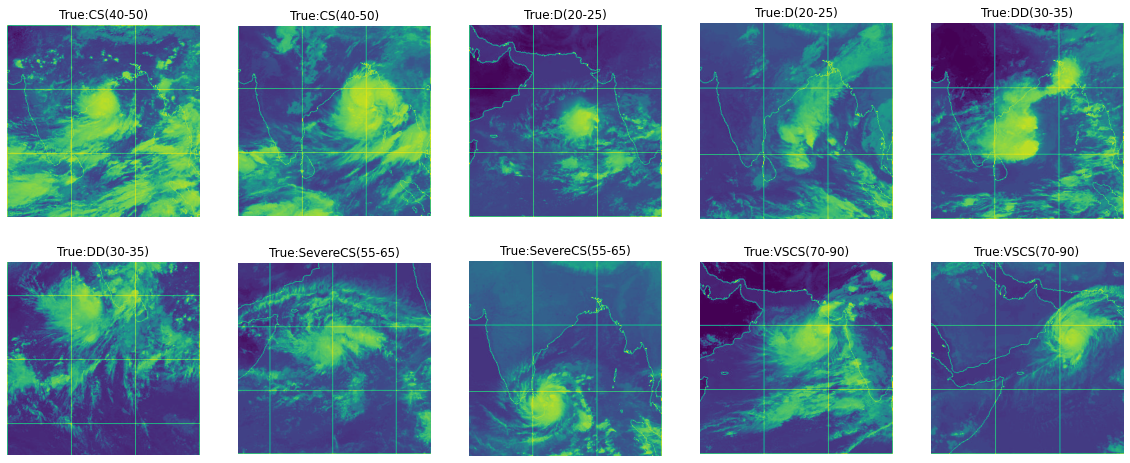

In [ ]:
show_few_images(2)

In [ ]:
vgg_epoch = 30
resnet_epoch = 15
inception_epoch = 20
own_epoch = 30

# **VGG-16 Model**

In [ ]:
tf.keras.backend.clear_session()

Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 2. Images of size each 150x150 with 3 color channels will be input into this layer

In [ ]:
vgg16_model = VGG16(pooling = 'avg', weights = 'imagenet', include_top = False, input_shape = (310, 310, 3))
for layers in vgg16_model.layers:
  layers.trainable = False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(5, activation = 'softmax')(vgg_x)
vgg16_final_model = Model(vgg16_model.input, vgg_x)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = [f1, 'acc'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)

In [ ]:
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

history = vgg16_final_model.fit(train_generator, epochs = vgg_epoch, validation_data = validation_generator, callbacks = [checkpoint, early_stopping], verbose = 1)

Epoch 1/30
737/737 [==============================] - ETA: 0s - loss: 1.5784 - f1: 0.0000e+00 - acc: 0.2872
Epoch 1: val_acc improved from -inf to 0.28841, saving model to vgg_16_-saved-model-01-acc-0.29.hdf5
737/737 [==============================] - 358s 474ms/step - loss: 1.5784 - f1: 0.0000e+00 - acc: 0.2872 - val_loss: 1.5815 - val_f1: 0.0000e+00 - val_acc: 0.2884
Epoch 2/30
737/737 [==============================] - ETA: 0s - loss: 1.5626 - f1: 0.0000e+00 - acc: 0.2987
Epoch 2: val_acc did not improve from 0.28841
737/737 [==============================] - 48s 65ms/step - loss: 1.5626 - f1: 0.0000e+00 - acc: 0.2987 - val_loss: 1.5721 - val_f1: 0.0000e+00 - val_acc: 0.2884
Epoch 3/30
737/737 [==============================] - ETA: 0s - loss: 1.5536 - f1: 0.0000e+00 - acc: 0.2872
Epoch 3: val_acc did not improve from 0.28841
737/737 [==============================] - 47s 63ms/step - loss: 1.5536 - f1: 0.0000e+00 - acc: 0.2872 - val_loss: 1.5673 - val_f1: 0.0000e+00 - val_acc: 0.283

In [ ]:
vgg16_final_model.save('/content/drive/MyDrive/multiclass_vgg_model.hdf5')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


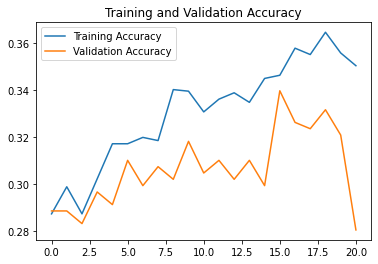

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


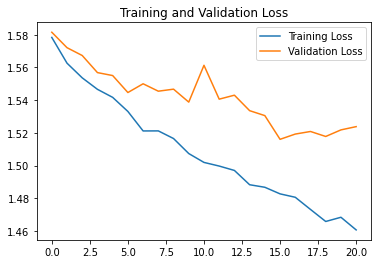

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


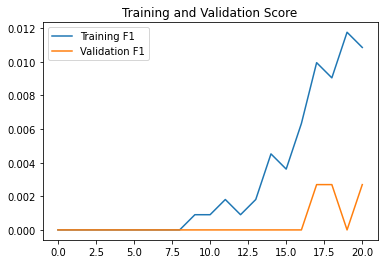

<Figure size 432x288 with 0 Axes>

In [ ]:
do_history_stuff(history, 'vgg16_model')

In [ ]:
vgg_best_model = vgg16_final_model
true_value = []
vgg_pred = []
for folder in os.listdir(val_folders):
    val_image_ids = os.listdir(os.path.join(val_folders,folder))
    for image_id in val_image_ids[:int(len(val_image_ids))]:
        path = os.path.join(val_folders, folder, image_id)
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(310, 310))
        img_normalized = img/255
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)

In [ ]:
def clf_report(true_value, model_pred):
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],horizontalalignment="center", color="black" if cm[i,j] > thresh else "white")
        pass
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.33962264150943394
                 precision    recall  f1-score   support

      CS(40-50)       0.32      0.31      0.32        80
       D(20-25)       0.31      0.55      0.40        71
      DD(30-35)       0.41      0.30      0.34       107
SevereCS(55-65)       0.10      0.02      0.03        52
    VSCS(70-90)       0.36      0.48      0.41        61

       accuracy                           0.34       371
      macro avg       0.30      0.33      0.30       371
   weighted avg       0.32      0.34      0.32       371



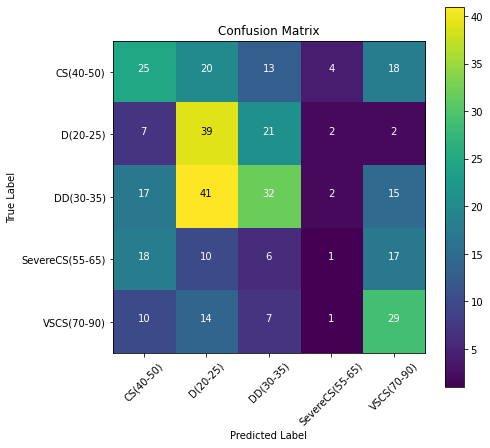

In [ ]:
clf_report(true_value, vgg_pred)

# **ResNet-50 Model**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
ResNet50_model = ResNet50(weights='imagenet', include_top = False, input_shape = (310,310,3), classes=5)
for layers in ResNet50_model.layers:
    layers.trainable = True

# resnet50_x = Conv2D(64, (3, 3), activation='relu')(ResNet50_model.output)
# resnet50_x = MaxPooling2D(pool_size=(3, 3))(resnet50_x)
resnet50_x = Flatten()(ResNet50_model.output)
resnet50_x = Dense(256,activation='relu')(resnet50_x)
resnet50_x = Dense(5,activation='softmax')(resnet50_x)
resnet50_x_final_model = Model(inputs = ResNet50_model.input, outputs = resnet50_x)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.0001), metrics = ['acc', f1])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.05, patience = 5, min_lr = 0.00002)

In [ ]:
history = resnet50_x_final_model.fit(train_generator, epochs = resnet_epoch, validation_data = validation_generator,
                                              callbacks= [early_stopping,reduce_lr], verbose=1)

In [ ]:
resnet50_x_final_model.save('/content/drive/MyDrive/multiclass_resnet_model.hdf5')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


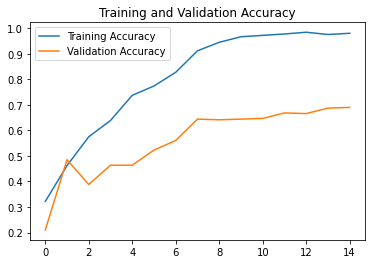

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


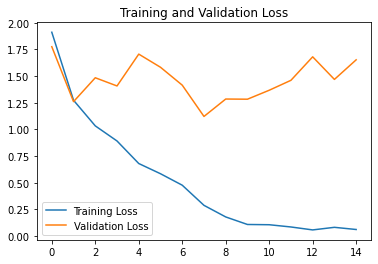

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


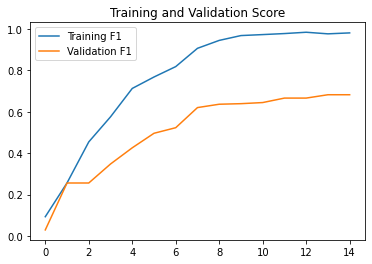

<Figure size 432x288 with 0 Axes>

In [ ]:
do_history_stuff(history, 'resnet50_model')

In [ ]:
resnet_best_model = resnet50_x_final_model
resnet_pred = []
true_value = []
for folder in os.listdir(val_folders):
    val_image_ids = os.listdir(os.path.join(val_folders,folder))
    for image_id in val_image_ids[:int(len(val_image_ids))]:
        path = os.path.join(val_folders,folder,image_id)
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(310,310))
        img_normalized = img/255
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)

In [ ]:
def clf_report(true_value, model_pred):
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.6792452830188679
                 precision    recall  f1-score   support

      CS(40-50)       0.63      0.55      0.59        80
       D(20-25)       0.73      0.66      0.70        71
      DD(30-35)       0.59      0.79      0.68       107
SevereCS(55-65)       0.77      0.58      0.66        52
    VSCS(70-90)       0.84      0.75      0.79        61

       accuracy                           0.68       371
      macro avg       0.71      0.67      0.68       371
   weighted avg       0.69      0.68      0.68       371



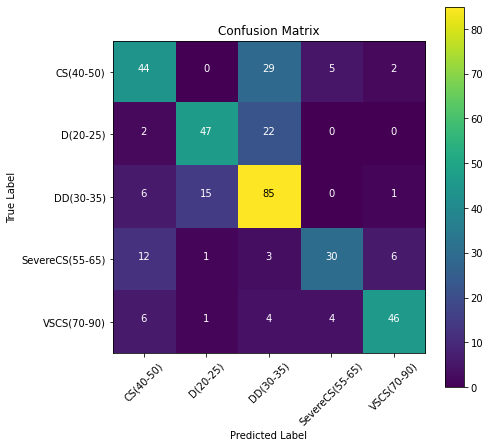

In [ ]:
clf_report(true_value, resnet_pred)

# **Inceptionv3 Model**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
InceptionV3_model = InceptionV3(input_shape = (310, 310, 3), weights = 'imagenet', include_top = False)
for layer in InceptionV3_model.layers[:249]:
   layer.trainable = False
for layer in InceptionV3_model.layers[249:]:
   layer.trainable = True

InceptionV3_last_output = InceptionV3_model.output
InceptionV3_maxpooled_output = Flatten()(InceptionV3_last_output)
InceptionV3_x = Dense(1024, activation = 'relu')(InceptionV3_maxpooled_output)
InceptionV3_x = Dropout(0.5)(InceptionV3_x)
InceptionV3_x = Dense(5, activation = 'softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(inputs = InceptionV3_model.input, outputs = InceptionV3_x)

87924736/87910968 [==============================] - 0s 0us/step


In [ ]:
InceptionV3_x_final_model.compile(optimizer = Adam(lr = 0.0001), loss = 'categorical_crossentropy', metrics = ['acc', f1])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)

In [ ]:
history = InceptionV3_x_final_model.fit(train_generator, epochs = inception_epoch, validation_data = validation_generator, callbacks = [early_stopping], verbose=1)

Epoch 1/20
737/737 [==============================] - 64s 78ms/step - loss: 3.1523 - acc: 0.2756 - f1: 0.1036 - val_loss: 1.4652 - val_acc: 0.3639 - val_f1: 0.0270
Epoch 2/20
737/737 [==============================] - 55s 74ms/step - loss: 1.5284 - acc: 0.3204 - f1: 0.0805 - val_loss: 1.4185 - val_acc: 0.3774 - val_f1: 0.0863
Epoch 3/20
737/737 [==============================] - 54s 74ms/step - loss: 1.4636 - acc: 0.3462 - f1: 0.1156 - val_loss: 1.3389 - val_acc: 0.3854 - val_f1: 0.1078
Epoch 4/20
737/737 [==============================] - 54s 74ms/step - loss: 1.4316 - acc: 0.3646 - f1: 0.1771 - val_loss: 1.3312 - val_acc: 0.4205 - val_f1: 0.1024
Epoch 5/20
737/737 [==============================] - 54s 73ms/step - loss: 1.3103 - acc: 0.4168 - f1: 0.2205 - val_loss: 1.3188 - val_acc: 0.4394 - val_f1: 0.2129
Epoch 6/20
737/737 [==============================] - 59s 80ms/step - loss: 1.2348 - acc: 0.4460 - f1: 0.2551 - val_loss: 1.2491 - val_acc: 0.4663 - val_f1: 0.1995
Epoch 7/20
737/7

In [ ]:
InceptionV3_x_final_model.save('/content/drive/MyDrive/multiclass_inception_model.hdf5')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


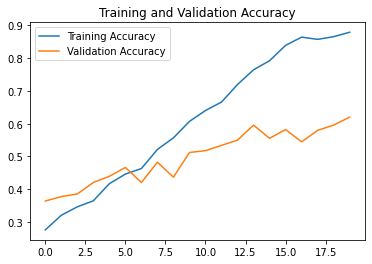

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


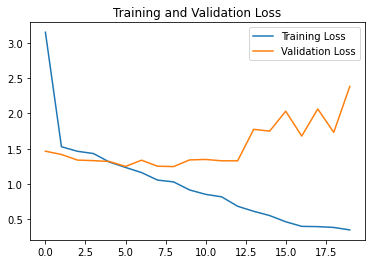

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


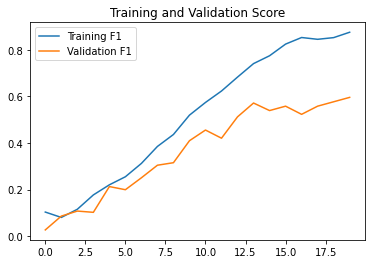

<Figure size 432x288 with 0 Axes>

In [ ]:
do_history_stuff(history, 'inceptionv3_model', True)

In [ ]:
inception_best_model = InceptionV3_x_final_model
true_value = []
inception_pred = []
for folder in os.listdir(val_folders):
    test_image_ids = os.listdir(os.path.join(val_folders,folder))
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        path = os.path.join(val_folders,folder,image_id)
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(310,310))
        img_normalized = img/255
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)

In [ ]:
def clf_report(true_value, model_pred):
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.6064690026954178
                 precision    recall  f1-score   support

      CS(40-50)       0.53      0.64      0.58        80
       D(20-25)       0.70      0.56      0.62        71
      DD(30-35)       0.69      0.62      0.65       107
SevereCS(55-65)       0.46      0.48      0.47        52
    VSCS(70-90)       0.64      0.70      0.67        61

       accuracy                           0.61       371
      macro avg       0.60      0.60      0.60       371
   weighted avg       0.62      0.61      0.61       371



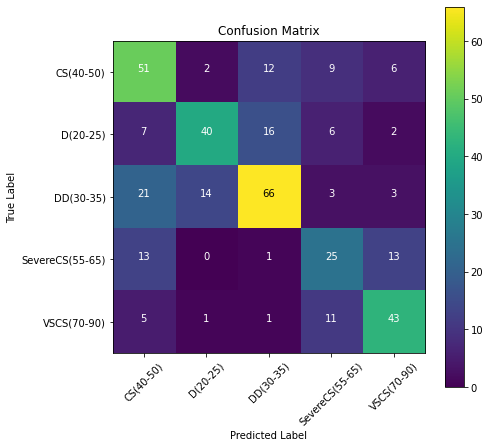

In [ ]:
clf_report(true_value, inception_pred)

# **Own Model**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
own_model = tf.keras.models.Sequential([
tf.keras.layers.Conv2D(32, (3, 3), input_shape = (310, 310, 3), activation = 'relu', name = 'Conv1'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', name = 'Conv2'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', name = 'Conv3'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu', name = 'Conv4'),
tf.keras.layers.MaxPooling2D(pool_size = (2, 2)),
tf.keras.layers.Dropout(0.2),

tf.keras.layers.Flatten(),

tf.keras.layers.Dropout(0.4),

tf.keras.layers.Dense(units = 512, activation = 'relu', name = 'FC1'),

tf.keras.layers.Dropout(0.3),

tf.keras.layers.Dense(5, activation = 'softmax', name = 'FC2')
])

In [ ]:
own_model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = [f1, 'acc'])

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor = 0.05, patience = 5, min_lr = 0.00002)
#checkpoint = tf.keras.callbacks.ModelCheckpoint(monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience=3)

In [ ]:
history = own_model.fit(train_generator, epochs = own_epoch, verbose = 1, validation_data = validation_generator, callbacks = [reduce_lr, early_stopping])

Epoch 1/30
737/737 [==============================] - 48s 63ms/step - loss: 1.6004 - f1: 0.0079 - acc: 0.2688 - val_loss: 1.5932 - val_f1: 0.0000e+00 - val_acc: 0.2884 - lr: 1.0000e-04
Epoch 2/30
737/737 [==============================] - 39s 53ms/step - loss: 1.5752 - f1: 0.0018 - acc: 0.2872 - val_loss: 1.5718 - val_f1: 0.0000e+00 - val_acc: 0.3396 - lr: 1.0000e-04
Epoch 3/30
737/737 [==============================] - 39s 53ms/step - loss: 1.5170 - f1: 0.0179 - acc: 0.3265 - val_loss: 1.5322 - val_f1: 0.0216 - val_acc: 0.3477 - lr: 1.0000e-04
Epoch 4/30
737/737 [==============================] - 39s 53ms/step - loss: 1.4784 - f1: 0.0475 - acc: 0.3714 - val_loss: 1.5302 - val_f1: 0.0000e+00 - val_acc: 0.3288 - lr: 1.0000e-04
Epoch 5/30
737/737 [==============================] - 39s 53ms/step - loss: 1.4458 - f1: 0.0900 - acc: 0.3700 - val_loss: 1.5295 - val_f1: 0.0512 - val_acc: 0.3315 - lr: 1.0000e-04
Epoch 6/30
737/737 [==============================] - 38s 52ms/step - loss: 1.3935 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


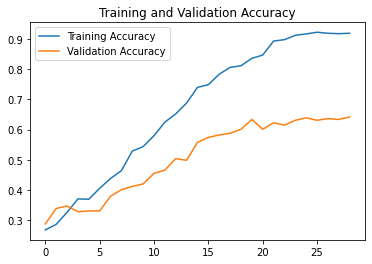

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


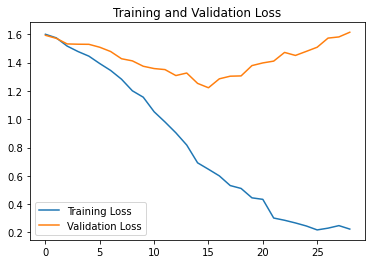

<Figure size 432x288 with 0 Axes>

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


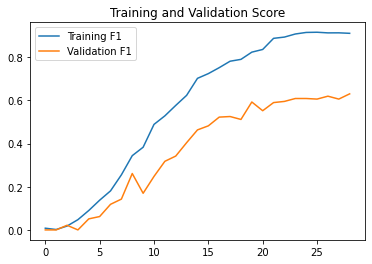

<Figure size 432x288 with 0 Axes>

In [ ]:
do_history_stuff(history, 'own_model')

In [ ]:
true_value = []
own_model_pred = []
for folder in os.listdir(val_folders):
    val_image_ids = os.listdir(os.path.join(val_folders,folder))
    
    for image_id in val_image_ids[:int(len(val_image_ids))]: 
        path = os.path.join(val_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(310,310))
        img_normalized = img/255
        own_model_prediction = np.argmax(own_model.predict(np.array([img_normalized])))
        own_model_pred.append(own_model_prediction)

In [ ]:
def clf_report(true_value, model_pred):
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

In [ ]:
own_model.save('/content/drive/MyDrive/multiclass_own_model.hdf5')

Model Accuracy 0.628032345013477
                 precision    recall  f1-score   support

      CS(40-50)       0.59      0.60      0.59        80
       D(20-25)       0.77      0.56      0.65        71
      DD(30-35)       0.64      0.71      0.68       107
SevereCS(55-65)       0.48      0.56      0.51        52
    VSCS(70-90)       0.69      0.66      0.67        61

       accuracy                           0.63       371
      macro avg       0.63      0.62      0.62       371
   weighted avg       0.64      0.63      0.63       371



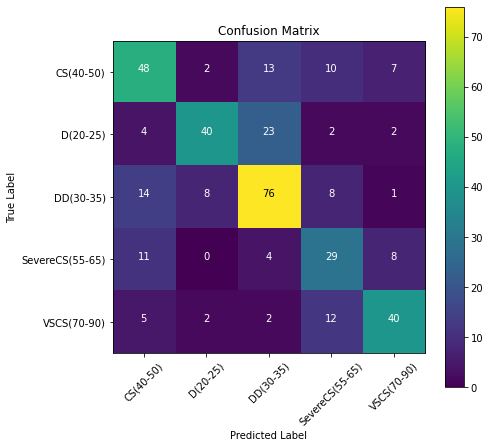

In [ ]:
clf_report(true_value, own_model_pred)

# **Ensemble Model**

In [ ]:
vgg_best_model = load_model('/content/drive/MyDrive/multiclass_vgg_model.hdf5', custom_objects = {'f1':f1})
resnet_best_model = load_model('/content/drive/MyDrive/multiclass_resnet_model.hdf5', custom_objects = {'f1':f1})
inception_best_model = load_model('/content/drive/MyDrive/multiclass_inception_model.hdf5', custom_objects = {'f1':f1})
own_best_model = load_model('/content/drive/MyDrive/multiclass_own_model.hdf5', custom_objects = {'f1':f1})

In [ ]:
def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []
vgg_pred = []
resnet_pred = []
inception_pred = []
benchmark_model_pred = []
own_model_pred = []
for folder in os.listdir(val_folders):
    
    test_image_ids = os.listdir(os.path.join(val_folders,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(val_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(310,310))
        img_normalized = img/255
        
        #vgg16
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)
        
        #resnet50
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img_normalized])))
        resnet_pred.append(resnet_50_image_prediction)
        
        #Inception
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img_normalized])))
        inception_pred.append(inception_image_prediction)

        #own
        own_model_prediction = np.argmax(own_best_model.predict(np.array([img_normalized])))
        own_model_pred.append(own_model_prediction)
        
        #giving own model high priority if they all predict something different
        image_prediction = mode([own_model_prediction,  resnet_50_image_prediction, inception_image_prediction, vgg16_image_prediction])                                
        combined_model_pred.append(image_prediction)

In [ ]:
def clf_report(true_value, model_pred):
    classes = validation_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize = (7, 7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))

Model Accuracy 0.6576819407008087
                 precision    recall  f1-score   support

      CS(40-50)       0.61      0.61      0.61        80
       D(20-25)       0.77      0.65      0.70        71
      DD(30-35)       0.63      0.73      0.68       107
SevereCS(55-65)       0.56      0.52      0.54        52
    VSCS(70-90)       0.75      0.72      0.73        61

       accuracy                           0.66       371
      macro avg       0.66      0.65      0.65       371
   weighted avg       0.66      0.66      0.66       371



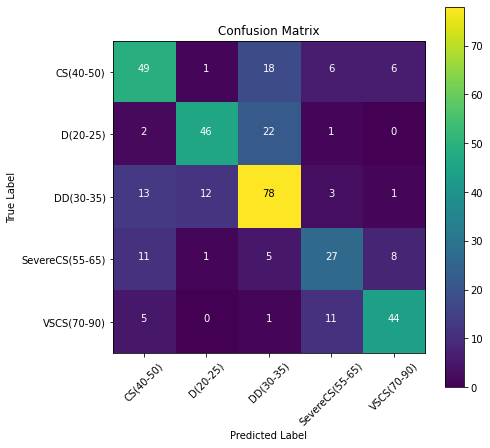

In [ ]:
combined_model_pred = [c[0] for c in combined_model_pred]
clf_report(true_value, combined_model_pred)